In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
# %matplotlib widget

In [2]:
fp_b = r"data\04_oct_cleaned_pickled_batter_data.pkl"
fp_p = r"data\04_oct_cleaned_pickled_pitcher_data.pkl"

In [3]:
b_raw = pd.read_pickle(fp_b)
p_raw = pd.read_pickle(fp_p)

In [4]:
dims = ["player_name", "year", "team"]
xdims = ["age", "position"]
sal = ["salary", "log_salary", "next_year_salary", "next_year_log_salary", "league_min", "salary_over_minimum", "player_at_min"]
stats = ["avg", "hr", "obp", "ops", "pa", "rbi", "slg", "war"]

## Salaries over time

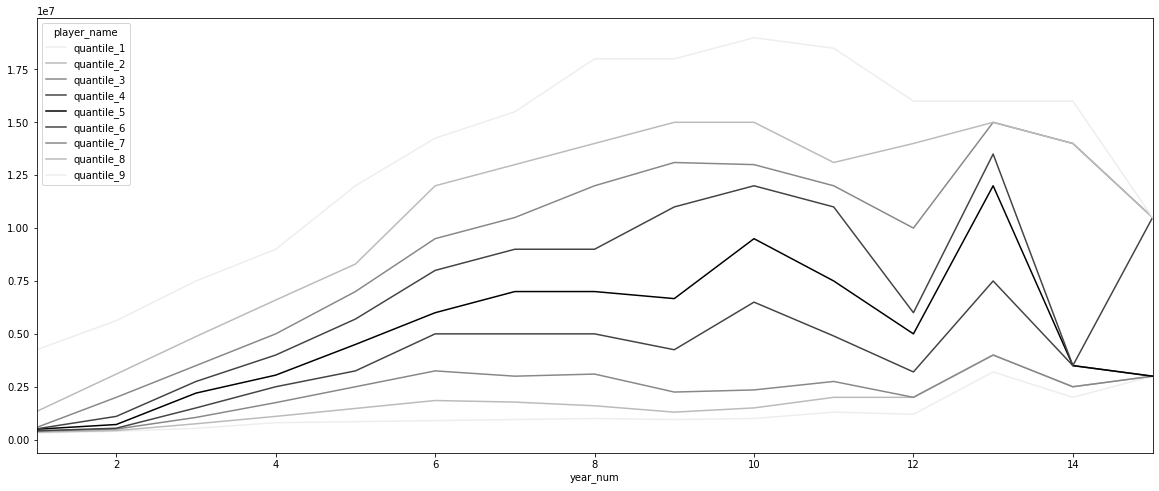

In [5]:
def coerce_level(df, level):
    df.columns = df.columns.get_level_values(level)
    return df

metric = "log_salary"

(b_raw
 [dims + [metric]]
 .sort_values(dims)
 .pipe(lambda df: df.assign(next_salary=df.groupby(["player_name"])[metric].shift(-1)))
 .pipe(lambda df: df.assign(diff = df.next_salary - df[metric]))
 .assign(one=1)
 .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
 .drop(["year", "team", "next_salary", "diff", "one"], axis=1)
 .pipe(lambda df: df.assign(weight=df.groupby("player_name")[metric].transform('count')))
 .sort_values(["weight", "player_name", "year_num"], ascending=[False, True, True])
 .set_index(["player_name", "year_num", "weight"])
 .unstack(["player_name", "weight"])
 .pipe(lambda df: coerce_level(df, 1))
 .pipe(lambda df: df.assign(**{f"quantile_{i}": df.quantile(i/10, axis=1, interpolation='nearest') for i in range(1, 10)}))
 .pipe(lambda df: df[[c for c in df.columns if c.startswith("quantile")]])
 .apply(np.exp)
 .plot(figsize=(20,8), color=["#eeeeee", "#bbbbbb", "#888888", "#444444", "#000000", "#444444", "#888888", "#bbbbbb", "#eeeeee"])
);


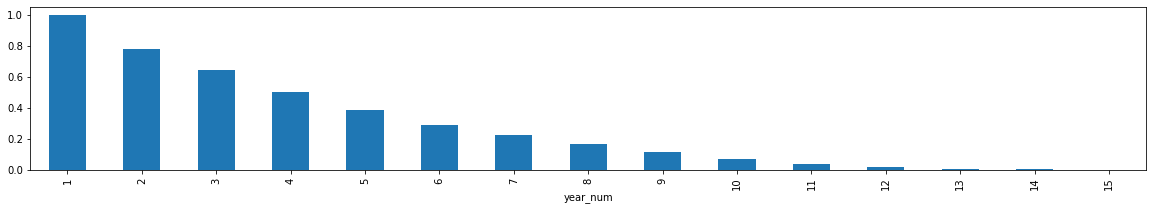

In [6]:
(b_raw
 [dims + [metric]]
 .sort_values(dims)
 .assign(one=1)
 .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
 .groupby("year_num")
 ["one"]
 .count()
 .to_frame()
 .pipe(lambda df: df.assign(fraction_remaining=df.one / df.one.max()))
 ["fraction_remaining"]
 .plot(kind="bar", figsize=(20,3))
);

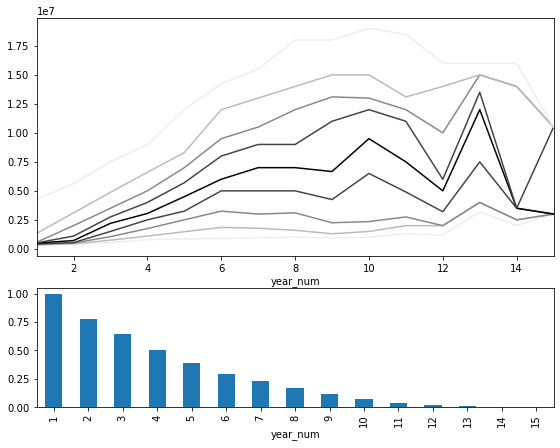

In [7]:
fig, axs = plt.subplots(2, 1,
                        figsize=(8, 6),
                       gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout()

(b_raw
 [dims + [metric]]
 .sort_values(dims)
 .assign(one=1)
 .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
 .drop(["year", "team", "one"], axis=1)
 .pipe(lambda df: df.assign(weight=df.groupby("player_name")[metric].transform('count')))
 .sort_values(["weight", "player_name", "year_num"], ascending=[False, True, True])
 .set_index(["player_name", "year_num", "weight"])
 .unstack(["player_name", "weight"])
 .pipe(lambda df: coerce_level(df, 1))
 .pipe(lambda df: df.assign(**{f"quantile_{i}": df.quantile(i/10, axis=1, interpolation='nearest') for i in range(1, 10)}))
 .pipe(lambda df: df[[c for c in df.columns if c.startswith("quantile")]])
 .apply(np.exp)
 .plot(color=["#eeeeee", "#bbbbbb", "#888888", "#444444", "#000000", "#444444", "#888888", "#bbbbbb", "#eeeeee"], ax=axs[0], legend=None)
);

(b_raw
 [dims + [metric]]
 .sort_values(dims)
 .assign(one=1)
 .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
 .groupby("year_num")
 ["one"]
 .count()
 .to_frame()
 .pipe(lambda df: df.assign(fraction_remaining=df.one / df.one.max()))
 ["fraction_remaining"]
 .plot(kind="bar", ax=axs[1])
);

Salaries are higher for players (non-pitchers) that have been in the league longer.  In the first year, there is a large upwards skew in the salaries that a lucky few players make, with almost all other players clustering around a low number.  As time goes on, the distribution widens significantly for players that remain in the league.  Salaries peak at about 10 years, with the top 10% making roughly twice the median and more than 10x the bottom 10%.  Only about 10% of players make it to this point in their career.  After 10 years, so few players remain that the salary distribution is noisy.

## Salaries over time, correlated with player statistics

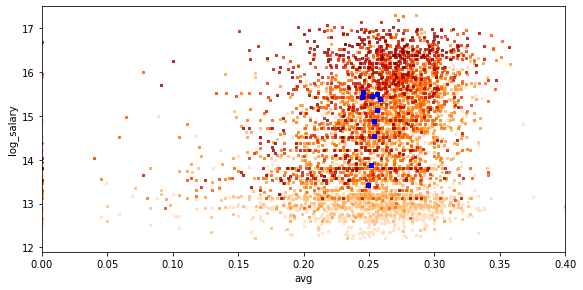

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig.tight_layout()
ax.set_xlim(0, 0.4)
ax.set_ylim(11.9, 17.5)
yrs = 10

for i in range(1, yrs+1):
    (b_raw
     [dims + ["log_salary", "avg"]]
     .sort_values(dims)
     .assign(one=1)
     .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
     .drop(["year", "team", "one", "player_name"], axis=1)
     .pipe(lambda df: df[df.year_num == i])
#      .pipe(lambda df: df.assign(log_salary=df["log_salary"].apply(np.exp)))  # uncomment to plot re-transformed salary
     .plot.scatter(x="avg", y="log_salary",
                   color=plt.get_cmap("gist_heat_r")(i/(yrs*3/2)),
                   alpha=0.75,
                   ax=ax,
                   marker=",",
                   s=1.5)
    )

for i in range(1, yrs+1):
    (b_raw
     [dims + ["log_salary", "avg"]]
     .sort_values(dims)
     .assign(one=1)
     .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
     .drop(["year", "team", "one", "player_name"], axis=1)
     .pipe(lambda df: df[df.year_num == i])
     [["log_salary", "avg"]]
     .mean()
     .to_frame()
     .T
#      .pipe(lambda df: df.assign(log_salary=df["log_salary"].apply(np.exp)))  # uncomment to plot re-transformed salary
     .plot.scatter(x="avg", y="log_salary",
                   ax=ax,
                   marker='s',
                   color="blue",
                   s=10)
    )

May be able to animate using the snippet from: `https://stackoverflow.com/questions/46982193/consecutive-matplotlib-animation-in-same-figure`

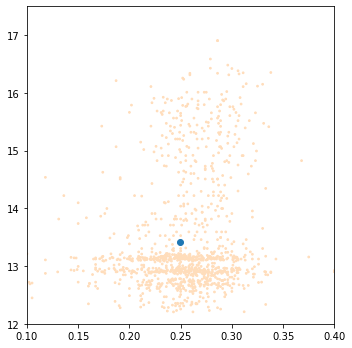

In [9]:
class AnimationHandler:
    def __init__(self, data, ax):

        self.ax = ax
        self.data = data
        self.n_steps = 10
        
    def update_scatter(self, step):
        d = (self.data
             [dims + ["log_salary", "avg"]]
             .sort_values(dims)
             .assign(one=1)
             .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
             .drop(["year", "team", "one", "player_name"], axis=1)
             .pipe(lambda df: df[df.year_num <= step])
             .sort_values("year_num", ascending=True)
            )
        self.ax.scatter(d["avg"], d["log_salary"],
                        color=plt.get_cmap("gist_heat_r")(d["year_num"] / self.n_steps * (2/3)),
                        s=3)
        
    def update_center(self, step):
        d = (self.data
             [dims + ["log_salary", "avg"]]
             .sort_values(dims)
             .assign(one=1)
             .pipe(lambda df: df.assign(year_num=df.groupby(["player_name"]).one.cumsum()))
             .drop(["year", "team", "one", "player_name"], axis=1)
             .pipe(lambda df: df[df.year_num == step])
             [["log_salary", "avg"]]
             .mean()
             .to_frame()
             .T
            )
        self.ax.scatter(d["avg"], d["log_salary"])

    def animate(self, step):
        self.ax.clear()
        self.ax.set_xlim(0.1, 0.4)
        self.ax.set_ylim(12, 17.5)
        self.update_scatter(step)
        self.update_center(step)
        
fig, axes = plt.subplots(figsize=(5, 5))
fig.tight_layout()
animator = AnimationHandler(ax=axes, data=b_raw)
my_animation = animation.FuncAnimation(fig,
                                       func=animator.animate,
                                       frames=list(range(1, animator.n_steps+1)),
                                       interval=800,
                                       repeat=True)
plt.show()